In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (confusion_matrix, precision_score, 
                             recall_score, f1_score,
                             precision_recall_curve,
                             roc_curve,
                             roc_auc_score,
                            )

plt.style.use('seaborn')

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
# setting out the features and label array 
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
X.dtype, y.dtype

(dtype('float64'), dtype('O'))

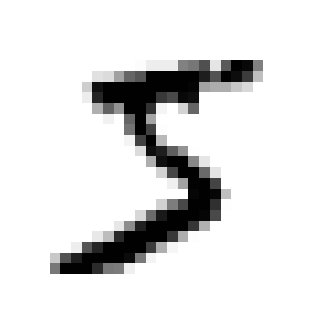

In [6]:
# viewing an image sample
'''steps : grab a row(s), 
        reshape the row, 
        pass the reshaped row to matplotlib's imshow() function
'''
some_digit = X[0] # first three digits
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
# label of the image above
y[0]

'5'

In [8]:
# change the data type of the label from object to integer
y = y.astype(np.uint8)

### Creating a test and train set

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [11]:
X_test.shape,y_test.shape

((10000, 784), (10000,))

### Train a Binary Classifier
Training a model to distinguish between two classes

In [12]:
# We are going to distinguish betwen the class is_5 and not_5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#### Using Stochastic Gradient Descent (SGD) classifier

In [13]:
sgd_clf = SGDClassifier(random_state=42, n_jobs=-1).fit(X_train, y_train_5)
sgd_clf.score(X_train, y_train_5)

0.9522666666666667

In [14]:
sgd_clf.predict([some_digit])

array([ True])

##  Performance Measures

### Using cross validation score

In [15]:
cross_score = cross_val_score(sgd_clf, X_train , y_train_5, cv=3, scoring='accuracy')
cross_score

array([0.95035, 0.96035, 0.9604 ])

In [16]:
mean_score = np.mean(cross_score)
mean_score

0.9570333333333334

### Using confusion matrix
The confusion matrix gives an idea of how well the classifier can predict the actual value.

In [17]:
y_train_preds = cross_val_predict(sgd_clf, X_train, y_train_5,
                                 cv=3) # predicted class
conf_mat = confusion_matrix(y_train_5, y_train_preds) # calculating the confusion matrix
conf_mat

array([[53892,   687],
       [ 1891,  3530]])

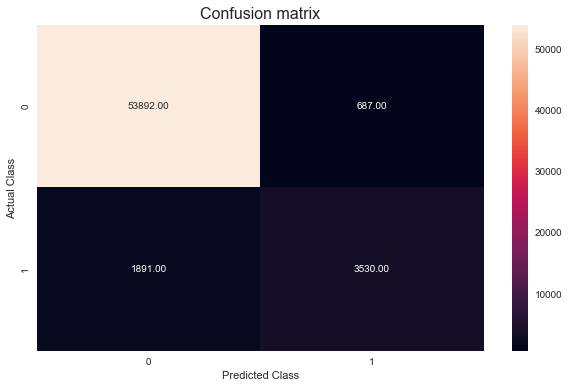

In [18]:
# lets visualize the confusion matrix using a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(conf_mat, annot=True, fmt='.2f')
plt.title('Confusion matrix', fontsize=16)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

### Using Precision score

In [19]:
precision_score(y_train_5, y_train_preds) # precision score

0.8370879772350012

In [20]:
# manual calculation of precision
3530 / (3530+687)

0.8370879772350012

### Using Recall score

In [21]:
recall_score(y_train_5, y_train_preds) # recall score

0.6511713705958311

In [22]:
# manual calculation of recall
3530 / (3530+1891)

0.6511713705958311

### Using F1_score

In [23]:
f1_score(y_train_5, y_train_preds)

0.7325171197343846

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')
precison, recall, threshold = precision_recall_curve(y_train_5, y_scores)

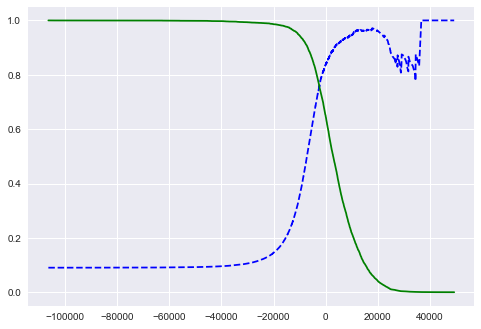

In [27]:
def plot_precision_recall_curve(precision, recall, threshold):
    fig, ax = plt.subplots()
    plt.plot(threshold, precision[:-1], 'b--', label='precision')
    plt.plot(threshold, recall[:-1], 'g-', label='recall')
    plt.show()

plot_precision_recall_curve(precison, recall, threshold)

### ROC Curve

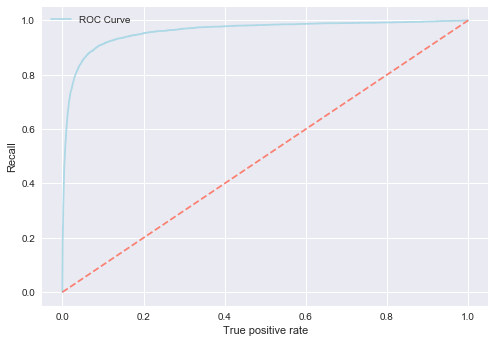

In [28]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label='ROC Curve', color='lightblue')
    plt.plot([0, 1], [0, 1], 'k--', color='salmon')
    plt.ylabel('Recall')
    plt.xlabel('True positive rate')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

### The AUC_Curve

In [29]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Trying RandomForestClassifier

In [30]:
rf_clf = RandomForestClassifier().fit(X_train, y_train_5)
y_pred = cross_val_predict(rf_clf, X_train, y_train_5, method='predict_proba', cv=3)

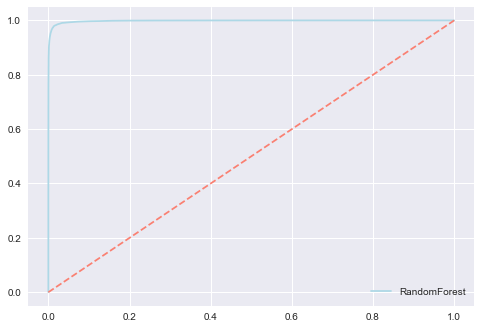

In [31]:
y_score_pos = y_pred[:, 1]
fpr_forest, tpr_forest, threshold = roc_curve(y_train_5, y_score_pos)

plt.plot(fpr_forest, tpr_forest, 'b-', label='RandomForest',  color='lightblue')
plt.plot([0, 1], [0, 1], 'k--', color='salmon')
plt.legend()
plt.show()

In [32]:
y_preds = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, n_jobs=-1)

In [33]:
precision_score(y_train_5, y_preds)

0.989008666243923

In [34]:
recall_score(y_train_5, y_preds)

0.8631248847076185

# Multiclass Classification

In [35]:
from sklearn.svm import SVC

sgd_clf = SVC().fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [36]:
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [37]:
np.argmax(some_digit_score)

5

In [38]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [39]:
sgd_clf.classes_[5]

5

In [40]:
# from sklearn.multiclass import OneVsRestClassifier
# ovr_clf = OneVsRestClassifier(SVC(), n_jobs=-1)
# ovr_clf.fit(X_train , y_train)
# ovr_clf.predict([some_digit])

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled[:1000], y_train[:1000], cv=3, scoring="accuracy", n_jobs=-1)

array([0.85329341, 0.82282282, 0.84684685])

### Error Analysis

In [50]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:10000], y_train[:10000],
                                 cv=3, n_jobs=-1)

In [53]:
conf_mat = confusion_matrix(y_train[:10000], y_train_pred)
conf_mat

array([[ 976,    0,   11,    3,    2,    2,    4,    2,    1,    0],
       [   0, 1100,    8,    2,    2,    3,    0,    6,    4,    2],
       [   6,    5,  916,   11,    8,    2,    7,   19,   15,    2],
       [   0,    7,   26,  927,    1,   18,    2,   35,    9,    7],
       [   0,    3,   21,    1,  912,    4,    3,    6,    0,   30],
       [   5,    5,    7,   30,    5,  775,   18,   10,    6,    2],
       [   7,    2,   10,    0,    4,   12,  960,   16,    3,    0],
       [   3,    7,    8,    3,   13,    0,    0,  999,    3,   34],
       [   5,   11,   25,   12,    7,   13,   13,   10,  843,    5],
       [   4,    2,    7,   17,   16,    2,    0,   40,    4,  886]])

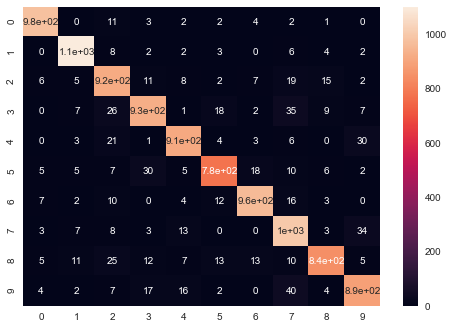

In [67]:
sns.heatmap(conf_mat, annot=True)
plt.show()

In [70]:
row_sum = conf_mat.sum(axis=1)
norm_conf_mat = conf_mat / row_sum

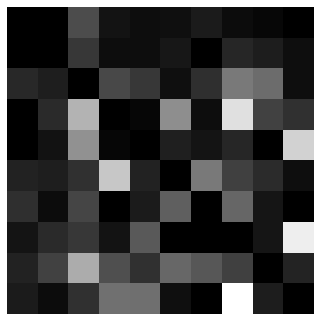

In [73]:
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap='gray')
plt.axis('off')
plt.show()